In [1]:
import pandas as pd
import nltk
import spacy
import re
import string,unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from py_lex import EmoLex
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

In [2]:
df = pd.read_csv("D:\\IIM\\Thesis\\Chap 2\\YelpChiInc.csv")
df.head()

,date,user_id,prod_id,rating,reviews,label,burst,PosSent,NegSent,CompSent,avg_PSent,med_PSent,fSent,inc,incentivised
0,2008-06-28,8332,182,1,I guess if you're as poor as me it'll do... bu...,0,1,0.24,0.06,0.97,0.334545,0.57,0.334545,0,0
1,2009-06-26,7661,182,5,I have walked by the Tokyo Hotel countless tim...,1,1,0.09,0.02,0.96,0.334545,0.57,0.334545,0,0
2,2010-02-05,17237,182,3,"This place is disgusting, absolutely horrible,...",1,0,0.04,0.12,-0.45,0.334545,0.57,0.334545,1,0
3,2010-02-11,33468,182,1,Here's the deal. If you want a cheap hotel in ...,0,0,0.17,0.05,0.57,0.334545,0.57,0.334545,0,0
4,2010-08-09,30468,182,1,Disgusting!!! There is literally duct tape hol...,1,1,0.00,0.29,-0.98,0.334545,0.57,0.334545,1,1


In [4]:
df.drop(['inc'], axis = 1,inplace=True)
df['label'].value_counts()

0    65189
1     2203
Name: incentivised, dtype: int64

In [6]:
df.iloc[:,:-1]

,date,user_id,prod_id,rating,reviews,label,burst,PosSent,NegSent,CompSent,avg_PSent,med_PSent,fSent
0,2008-06-28,8332,182,1,I guess if you're as poor as me it'll do... bu...,0,1,0.24,0.06,0.97,0.334545,0.570,0.334545
1,2009-06-26,7661,182,5,I have walked by the Tokyo Hotel countless tim...,1,1,0.09,0.02,0.96,0.334545,0.570,0.334545
2,2010-02-05,17237,182,3,"This place is disgusting, absolutely horrible,...",1,0,0.04,0.12,-0.45,0.334545,0.570,0.334545
3,2010-02-11,33468,182,1,Here's the deal. If you want a cheap hotel in ...,0,0,0.17,0.05,0.57,0.334545,0.570,0.334545
4,2010-08-09,30468,182,1,Disgusting!!! There is literally duct tape hol...,1,1,0.00,0.29,-0.98,0.334545,0.570,0.334545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67387,2011-08-10,14008,69,4,The BEST homemade corned beef hash EVER. Lovel...,1,1,0.54,0.00,0.88,0.935000,0.935,0.935000
67388,2012-05-18,14857,69,4,My hubby and I eat breakfast here every couple...,1,1,0.18,0.02,0.99,0.935000,0.935,0.935000
67389,2009-01-22,14087,108,5,"Ok, I will admit, I haven't actually purchased...",1,1,0.27,0.05,0.99,0.985000,0.985,0.985000
67390,2009-06-09,33337,108,5,I found this bright yellow truck one day right...,1,1,0.21,0.00,0.98,0.985000,0.985,0.985000


In [8]:
ros = RandomUnderSampler(random_state=777)
dfx, dfy = ros.fit_resample(df.iloc[:,:-1], df.incentivised)
print(dfx.shape)
df = pd.concat([dfx, dfy], axis = 1)
df['label'].value_counts()

(4406, 13)


0    2203
1    2203
Name: incentivised, dtype: int64

In [9]:
#2 Average User rating
temp= df.groupby(['user_id'])['rating'].agg(np.mean).reset_index()
temp.rename(columns={'rating':'avg_Urating'}, inplace=True)
df = pd.merge(df, temp, how='outer', on=['user_id'])

In [10]:
#3 Average Product rating
temp= df.groupby(['prod_id'])['rating'].agg(np.mean).reset_index()
temp.rename(columns={'rating':'avg_Prating'}, inplace=True)
df = pd.merge(df, temp, how='outer', on=['prod_id'])

In [26]:
#4 User rating varience
df['Var_Urating'] = (df['rating']-df['avg_Urating'])**2
df.head()

,date,user_id,prod_id,rating,reviews,label,avg_Urating,avg_Prating,Var_Urating
0,7/25/2012,124,161,1,Do not believe ANYTHING on their cozy little w...,0,1.0,2.6,0.0
1,11/28/2011,13097,161,1,My husband and two young kids stayed in room 2...,0,1.0,2.6,0.0
2,5/13/2011,13822,161,4,This place is not for everyone. But it has a g...,0,4.0,2.6,0.0
3,5/3/2011,34531,161,4,"When I checked In initially, I was greeted wit...",0,4.0,2.6,0.0
4,10/23/2009,5498,161,3,The B & B's great location was the first reaso...,0,3.0,2.6,0.0


In [27]:
#5 Product rating varience
df['Var_Prating'] = (df['rating']-df['avg_Prating'])**2

In [11]:
#6 No. of reviews by a user
temp = df['user_id'].value_counts().rename_axis('user_id').to_frame('UCcounts')
df = pd.merge(df, temp, how='outer', on=['user_id'])

In [12]:
#7 No. of reviews by on a product
temp = df['prod_id'].value_counts().rename_axis('prod_id').to_frame('PCcounts')
df = pd.merge(df, temp, how='outer', on=['prod_id'])

In [13]:
#8 Avg word count in user review
df['#ofwords'] = df['reviews'].str.count(' ') + 1
temp = df.groupby(['user_id'])['#ofwords'].agg(np.mean).reset_index()
temp.rename(columns={'#ofwords':'Uavg#word'}, inplace=True)
df = pd.merge(df, temp, how='outer', on=['user_id'])

In [31]:
#9 Varience word count in user review
df['Uvar#word'] = (df['#ofwords'] - df['Uavg#word'])**2

In [14]:
#10 Avg word count in product review
temp = df.groupby(['prod_id'])['#ofwords'].agg(np.mean).reset_index()
temp.rename(columns={'#ofwords':'Pavg#word'}, inplace=True)
df = pd.merge(df, temp, how='outer', on=['prod_id'])

In [33]:
#11 Varience word count in product review
df['Pvar#word'] = (df['#ofwords'] - df['Pavg#word'])**2

In [15]:
#12 Maximum number of ratings provided on a date by user
temp = df.groupby(['date','user_id'])['rating'].agg(np.count_nonzero).reset_index()
temp.rename(columns={'rating':'day_Urating'}, inplace=True)
df = pd.merge(df, temp, how='outer', on=['date','user_id'])

In [16]:
#13 Maximum number of ratings received by a product on a date
temp = df.groupby(['date','prod_id'])['rating'].agg(np.count_nonzero).reset_index()
temp.rename(columns={'rating':'day_Prating'}, inplace=True)
df = pd.merge(df, temp, how='outer', on=['date','prod_id'])

In [18]:
#14 No of characters in a review
df['#ofCharacter'] = df['reviews'].apply(len)
#15 No of Upper case characters in a review
df['Uppercase'] = df['reviews'].str.findall(r'[A-Z]').str.len()
#16 No of Upper case characters in a review
df['Lowercase'] = df['reviews'].str.findall(r'[a-z]').str.len()

In [17]:
#17 Punctuation count
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
df['count_punct'] = df.reviews.apply(lambda s: count(s, string.punctuation))
#18 Exclaimation present
df['Exclaim'] = df['reviews'].str.contains("!") 

## Text Preprocessing

In [19]:
'''Lowercasing'''
df["reviews"] = df["reviews"].str.lower()
'''Removing Punctuations'''
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["reviews"] = df["reviews"].apply(lambda text: remove_punctuation(text))
'''Removing stopwords'''
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["reviews"] = df["reviews"].apply(lambda text: remove_stopwords(text))
'''Removal of URL'''
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
df["reviews"] = df["reviews"].apply(lambda text: remove_urls(text))
'''Spell Correction
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
df["reviews"] = df["reviews"].apply(lambda text: correct_spellings(text))'''

'Spell Correction\nspell = SpellChecker()\ndef correct_spellings(text):\n    corrected_text = []\n    misspelled_words = spell.unknown(text.split())\n    for word in text.split():\n        if word in misspelled_words:\n            corrected_text.append(spell.correction(word))\n        else:\n            corrected_text.append(word)\n    return " ".join(corrected_text)\ndf["reviews"] = df["reviews"].apply(lambda text: correct_spellings(text))'

In [39]:
# Lemmatization
sp = spacy.load('en_core_web_sm')
stops = stopwords.words("english")
def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = sp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


df['reviews'] = df['reviews'].apply(normalize, lowercase=False, remove_stopwords=False)

In [20]:
#18 Subjectivity
df['reviews'] = df.reviews.astype(str)
df['subjectivity'] = df['reviews'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)

In [41]:
#19 Sentiments
sid = SentimentIntensityAnalyzer()
def get_sentiment(row, **kwargs):
    sentiment_score = sid.polarity_scores(row)
    positive_meter = round((sentiment_score['pos']), 2)
    negative_meter = round((sentiment_score['neg']), 2) 
    return positive_meter if kwargs['k'] == 'positive' else negative_meter
df['positiveSent'] = df.reviews.apply(get_sentiment, k='positive')
df['negativeSent'] = df.reviews.apply(get_sentiment, k='negative')

In [21]:
#20 lexical Density
df['#ofwordswostp'] = df['reviews'].str.count(' ') + 1
df['le_d'] = (df['#ofwordswostp']/df['#ofwords'])*100
#21 Lexical Diversity
from lexical_diversity import lex_div as ld
df['ld'] = [ld.mtld(text) for text in df.reviews]

In [43]:
#22 Emotions
lexicon = EmoLex("C:\\Users\\Syed Abdullah Ashraf\\Desktop\\emolex.txt")
stopset=nltk.corpus.stopwords.words('english')
df['tokens'] = pd.Series(dtype=object)
for index, row in df.iterrows():
    try:
        tokens = word_tokenize(row['reviews'])
        tokens_wo_stopwords = [word for word in tokens if not word in stopset]
        df.at[index, 'tokens'] = tokens_wo_stopwords
    except:
        continue
df['anger'] = 0.0
df['anticipation'] = 0.0
df['disgust'] = 0.0
df['fear'] = 0.0
df['joy'] = 0.0
df['negative'] = 0.0
df['positive'] = 0.0
df['sadness'] = 0.0
df['surprise'] = 0.0
df['trust'] = 0.0
df['reviews']  = df['reviews'].str.lower() 
for index, _ in df.iterrows():
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        summary = lexicon.summarize_doc(to_lower)
        for key in summary.keys():
            df.at[index, key] = summary[key]
    except:
        continue

In [44]:
#Encoding
le = preprocessing.LabelEncoder()
df['Exclaim'] = le.fit_transform(df['Exclaim'])
df['label'] = le.fit_transform(df['label'])

In [45]:
df.drop(['date','tokens','positive','negative','#ofwordswostp'], axis = 1,inplace=True)

In [24]:
#23 Rating Entropy
g_sum = df.groupby('user_id')['rating'].transform('sum')
values = df['rating']/g_sum
df['Entropy'] = -(values*np.log(values))

In [611]:
#24 Similarity
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")
#temp = pd.DataFrame(X_new.toarray())
temp = pd.concat([df,temp],axis =1)
print(temp.shape)
temp = temp[temp['UCcounts']>1]
print(temp.shape)
from scipy import spatial
q = pd.DataFrame()
i=0
for user in temp['user_id'].unique():
    a = temp[temp['user_id'] == user]
    sim = cosine_similarity(a.iloc[:,37:], a.iloc[:,37:]).flatten()
    sim = set(sim)
    if len(sim)==1:
        #a['similarity'] = np.where(a['user_id']==user, max(sim),max(sim))
        a['similarity'] = max(sim)
    else:
        # removing the largest element from temp list 
        sim.remove(max(sim))
        if (max(sim))>0.9999999999999998:
            sim.remove(max(sim))
            #a['similarity'] = np.where(a['user_id']==user, max(sim),max(sim))
            a['similarity'] = max(sim)
        else:
            #a['similarity'] = np.where(a['user_id']==user, max(sim),max(sim))
            a['similarity'] = max(sim)
    q = pd.concat([q,a])
q.drop_duplicates(keep='first', inplace=True)
df = pd.merge(df,q[['user_id','prod_id','similarity']], how = 'left', on = ['user_id','prod_id'])
df = df.fillna(0)

(157874, 225)
(65458, 225)


In [23]:
#25 Extreme rating
df['Ext'] = df['rating'].apply(lambda x: 1 if (x==5 or x==0) else 0)
#26 Singleton
df['singleton'] = df['day_Urating'].apply(lambda x: 1 if (x==1) else 0)
#27 Ratio of CAPS/lower letter
df['ratio_LCAPS'] = df['Uppercase']/df['Lowercase']
df.replace([np.inf], 0,inplace=True)
df.replace([np.nan], 0,inplace=True)

In [613]:
#28 date_entropy
dfF = pd.read_csv("D:\\Datasets\\YelpZip\\YelpZip.csv")
temp = pd.merge(df,dfF[['user_id','prod_id','date']], how = 'left', on = ['user_id','prod_id'])
q = pd.DataFrame()
temp['date'] =pd.to_datetime(temp.date)
temp = temp.sort_values(by='date')
for user in temp['user_id'].unique():
    a = temp[temp['user_id']==user]
    a['date_entropy'] = abs(a["date"].diff(1))
    q = pd.concat([q,a])
q.drop_duplicates(keep='first', inplace=True)
q.date_entropy = pd.to_timedelta(q.date_entropy)
q['date_entropy'] = q['date_entropy'].fillna(pd.Timedelta(seconds = 0))
q['date_entropy'] = q['date_entropy'].apply(lambda x: x / np.timedelta64(1,'D'))
df = q

In [25]:
df.columns,df.shape

(Index(['date', 'user_id', 'prod_id', 'rating', 'reviews', 'label', 'burst',
        'PosSent', 'NegSent', 'CompSent', 'avg_PSent', 'med_PSent', 'fSent',
        'incentivised', 'avg_Urating', 'avg_Prating', 'UCcounts', 'PCcounts',
        '#ofwords', 'Uavg#word', 'Pavg#word', 'day_Urating', 'day_Prating',
        'count_punct', 'Exclaim', '#ofCharacter', 'Uppercase', 'Lowercase',
        'subjectivity', '#ofwordswostp', 'le_d', 'ld', 'Entropy', 'Ext',
        'singleton', 'ratio_LCAPS'],
       dtype='object'),
 (4406, 36))

In [47]:
df.to_csv("D:\\Yelp\\YelpChi\\YCProcessed.csv", index = False)

## TFIDF

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.02,max_df=0.50,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tfidf_reviews=tv.fit_transform(df['reviews'])
tfidf_reviews.shape

(17838, 559)

In [178]:
from sklearn.feature_selection import SelectFwe, chi2
X_new = SelectFwe(chi2, alpha = 0.01).fit_transform(tfidf_reviews, df.label)
X_new.shape

(17838, 11)

In [50]:
df1 = pd.DataFrame(X_new.toarray())
df1.to_csv("D:\\Yelp\\YelpChi\\YCtfidf.csv", index = False)

## Word 2 Vec

In [51]:
from bs4 import BeautifulSoup 
def review_wordlist(review, remove_stopwords=False):
    # 1. Removing html tags
    review_text = BeautifulSoup(review,"html.parser").get_text()
    review_text = re.compile('<.*?>').sub(r'', review)
    # 2. Removing non-letter.
    review_text = re.sub("[^a-zA-Z]"," ",review)
    # 3. Converting to lower case and splitting
    words = review_text.lower().split()
    # 4. Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops]
    
    return(words)
from nltk.tokenize.toktok import ToktokTokenizer
# Tokenizer initialization
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
def review_sentences(review, tokenizer, remove_stopwords=False):
    # 1. Using nltk tokenizer
    raw_sentences = tokenizer.tokenize(review.strip())
    #raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(review_wordlist(raw_sentence,\
                                            remove_stopwords))

    # This returns the list of lists
    return sentences
sentences = []
print("Parsing sentences from training set")
for reviews in df["reviews"]:
    sentences += review_sentences(reviews, tokenizer)
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(sentences,
                          workers=num_workers,
                          size=num_features,
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling,
                          seed = 22)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs
# Calculating average feature vector for training set
clean_reviews = []
for review in df['reviews']:
    clean_reviews.append(review_wordlist(review, remove_stopwords=True))
    
DataVecs = getAvgFeatureVecs(clean_reviews, model, num_features)
df1  = pd.DataFrame(DataVecs)

Parsing sentences from training set
Training model....
Review 0 of 17838


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide


Review 1000 of 17838
Review 2000 of 17838
Review 3000 of 17838
Review 4000 of 17838
Review 5000 of 17838
Review 6000 of 17838
Review 7000 of 17838
Review 8000 of 17838
Review 9000 of 17838
Review 10000 of 17838
Review 11000 of 17838
Review 12000 of 17838
Review 13000 of 17838
Review 14000 of 17838
Review 15000 of 17838
Review 16000 of 17838
Review 17000 of 17838


In [52]:
import pandas as pd
import numpy as np 
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(99,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist
df1, NAlist = reduce_mem_usage(df1)
df1.to_csv("D:\\Yelp\\YelpChi\\YCw2vcbow.csv", index = False)

Memory usage of properties dataframe is : 20.414093017578125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  20.414093017578125  MB
This is  100.0 % of the initial size


In [53]:
from bs4 import BeautifulSoup 
def review_wordlist(review, remove_stopwords=False):
    # 1. Removing html tags
    review_text = BeautifulSoup(review,"html.parser").get_text()
    review_text = re.compile('<.*?>').sub(r'', review)
    # 2. Removing non-letter.
    review_text = re.sub("[^a-zA-Z]"," ",review)
    # 3. Converting to lower case and splitting
    words = review_text.lower().split()
    # 4. Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops]
    
    return(words)
from nltk.tokenize.toktok import ToktokTokenizer
# Tokenizer initialization
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
def review_sentences(review, tokenizer, remove_stopwords=False):
    # 1. Using nltk tokenizer
    raw_sentences = tokenizer.tokenize(review.strip())
    #raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(review_wordlist(raw_sentence,\
                                            remove_stopwords))

    # This returns the list of lists
    return sentences
sentences = []
print("Parsing sentences from training set")
for reviews in df["reviews"]:
    sentences += review_sentences(reviews, tokenizer)
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(sentences,
                          workers=num_workers,
                          size=num_features,
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling,
                          sg =1,
                          seed = 22)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec
# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs
# Calculating average feature vector for training set
clean_reviews = []
for review in df['reviews']:
    clean_reviews.append(review_wordlist(review, remove_stopwords=True))
    
DataVecs = getAvgFeatureVecs(clean_reviews, model, num_features)
df1  = pd.DataFrame(DataVecs)

Parsing sentences from training set
Training model....
Review 0 of 17838


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


Review 1000 of 17838
Review 2000 of 17838
Review 3000 of 17838
Review 4000 of 17838
Review 5000 of 17838
Review 6000 of 17838
Review 7000 of 17838
Review 8000 of 17838
Review 9000 of 17838
Review 10000 of 17838
Review 11000 of 17838
Review 12000 of 17838
Review 13000 of 17838
Review 14000 of 17838
Review 15000 of 17838
Review 16000 of 17838
Review 17000 of 17838


In [54]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(99,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist
df1, NAlist = reduce_mem_usage(df1)
df1.to_csv("D:\\Yelp\\YelpChi\\YCw2vsg.csv", index = False)

Memory usage of properties dataframe is : 20.414093017578125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  20.414093017578125  MB
This is  100.0 % of the initial size


## GloVe

In [55]:
from nltk import punkt
from tqdm import tqdm
from scipy.sparse import hstack
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
embeddings_index = {}
f = open('glove.6B.300d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()
print('Found %s word vectors.' % len(embeddings_index))
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
x_glove = [sent2vec(x) for x in tqdm(df.reviews)]
df1  = pd.DataFrame(x_glove)

400000it [00:49, 8004.69it/s] 
  1%|          | 150/17838 [00:00<00:12, 1443.59it/s]

Found 400000 word vectors.


100%|██████████| 17838/17838 [00:18<00:00, 966.16it/s] 


In [56]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(99,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist
df1, NAlist = reduce_mem_usage(df1)
df1.to_csv("D:\\Yelp\\YelpChi\\YCglv.csv", index = False)

Memory usage of properties dataframe is : 40.82806396484375  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  20.414093017578125  MB
This is  50.000149493143496 % of the initial size


## Plotting

In [605]:
df = pd.read_csv("D:\\Yelp\\YelpZip\\YZProcessed.csv")
temp = pd.read_csv("D:\\Yelp\\YelpZip\\YZtfidf.csv")

In [608]:
print(temp.shape,q.shape,df.shape)

(157874, 188) (32699, 226) (157874, 37)


In [38]:
dfH = df[df['incentivised']==1]
dfS = df[df['incentivised']==0]

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


'dpi = 300, quality = 50)'

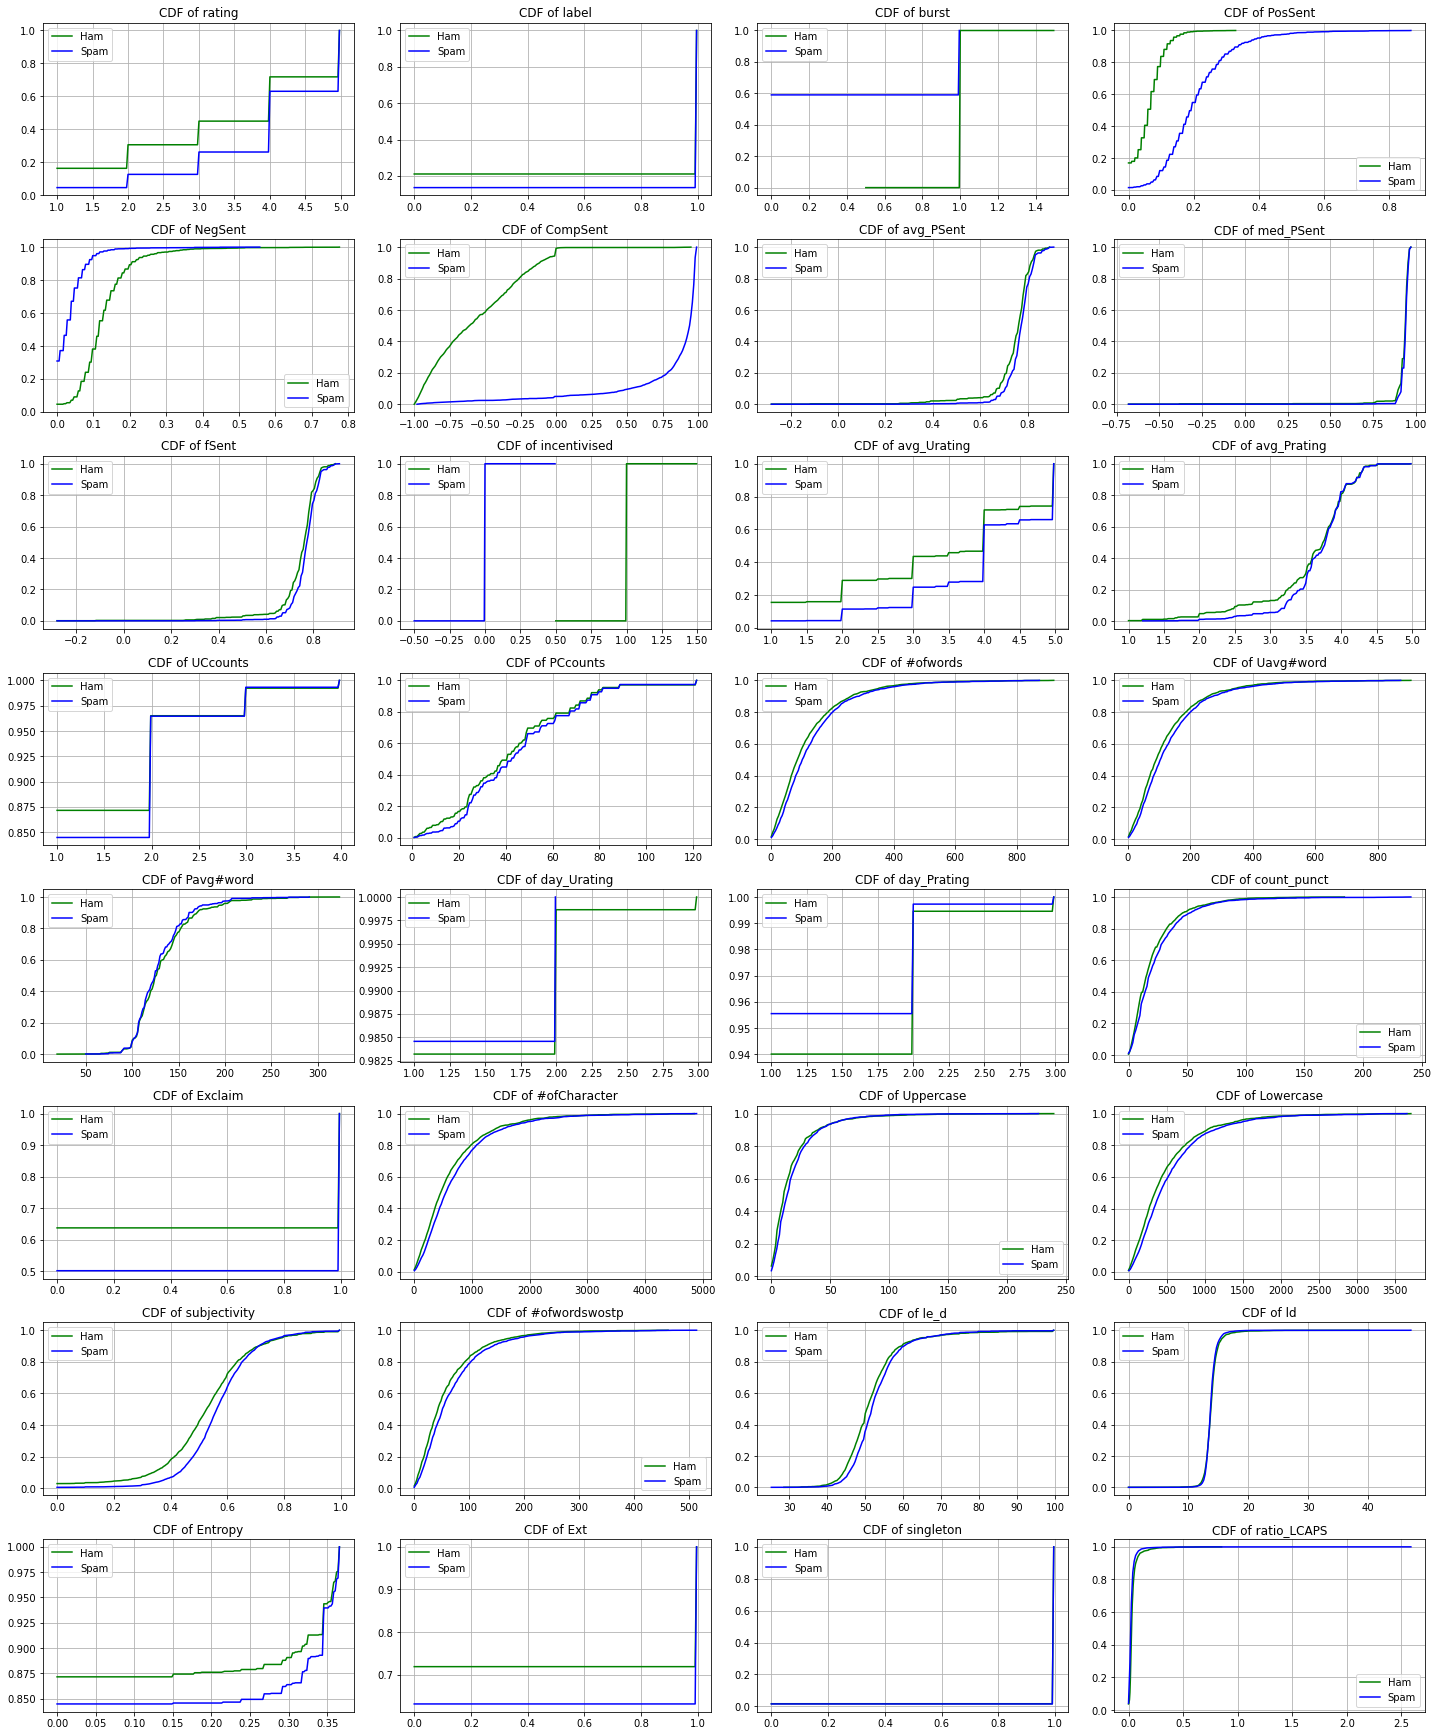

In [39]:
Features = ['avg_Urating','avg_Prating', 'Var_Urating', 'Var_Prating', 'UCcounts', 'PCcounts',
       '#ofwords', 'Uavg#word', 'Uvar#word', 'Pavg#word', 'Pvar#word',
       'day_Urating', 'day_Prating', '#ofCharacter', 'Uppercase', 'Lowercase',
       'count_punct', 'subjectivity', 'positiveSent',
       'negativeSent', 'le_d', 'ld', 'anger', 'anticipation', 'disgust',
       'fear', 'joy', 'sadness', 'surprise', 'trust','Entropy','similarity','Ext','singleton','ratio_LCAPS','date_entropy']
plt.rc('figure', max_open_warning = 0)
plt.figure(figsize=(20,30), facecolor='white')
plot_number = 1
for col in fest:
    values, base = np.histogram(dfH[col], bins=200, density = True)
    #evaluate the cumulative
    pdf = values/sum(values)
    cumulative = np.cumsum(pdf)
    # plot the cumulative function
    ax = plt.subplot(10, 4, plot_number)
    plt.plot(base[:-1], cumulative, c='Green',label = 'Ham')
    values, base = np.histogram(dfS[col], bins=200, density = True)
    #evaluate the cumulative
    pdf1 = values/sum(values)
    cumulative1 = np.cumsum(pdf1)
    # plot the cumulative function
    plt.plot(base[:-1], cumulative1, c='blue',label = 'Spam')
    plt.title('CDF of '+col)
    plt.grid()
    plt.legend()
    plot_number = plot_number + 1
    #plt.savefig('D:\\Yelp\\YelpChi\\'+col+'.png')
    #plt.show()
#plt.show()
plt.tight_layout()
#plt.savefig('D:\\Yelp\\YelpZip\\CDF.jpeg',dpi = 200,quality = 50)
'''dpi = 300, quality = 50)'''

In [6]:
df = pd.read_csv('D:\\Yelp\\YelpNYC\\YNProcessed.csv')
df.columns

Index(['user_id', 'prod_id', 'rating', 'reviews', 'label', 'avg_Urating',
       'avg_Prating', 'Var_Urating', 'Var_Prating', 'UCcounts', 'PCcounts',
       '#ofwords', 'Uavg#word', 'Uvar#word', 'Pavg#word', 'Pvar#word',
       'day_Urating', 'day_Prating', '#ofCharacter', 'Uppercase', 'Lowercase',
       'count_punct', 'Exclaim', 'subjectivity', 'positiveSent',
       'negativeSent', 'le_d', 'ld', 'anger', 'anticipation', 'disgust',
       'fear', 'joy', 'sadness', 'surprise', 'trust', 'Entropy', 'similarity',
       'Ext', 'singleton', 'ratio_LCAPS', 'date', 'date_entropy'],
      dtype='object')

In [36]:
pip install heatmapz

  Using cached heatmapz-0.0.4-py3-none-any.whl (5.8 kB)
Note: you may need to restart the kernel to use updated packages.


C:\Users\SYEDAB~1\AppData\Local\Temp/ipykernel_32068/3058417171.py:22: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('YN Corr.jpeg',dpi = 200,quality = 50)


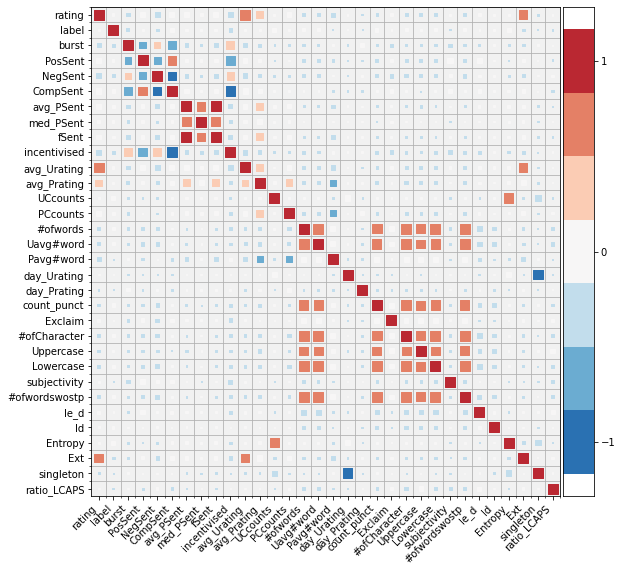

In [37]:
#pip install heatmapz
from heatmap import heatmap, corrplot
dftemp = df[fest].copy()
plt.figure(figsize=(9, 9))
plt.tight_layout()
plt.title('YelpZip Correlation Matrix')
#corrplot(df.corr(), size_scale=300)
def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette= sns.color_palette("RdBu_r", 7),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )
corrplot(dftemp.corr(),size_scale= 100)
plt.savefig('YN Corr.jpeg',dpi = 200,quality = 50)

In [15]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,avg_Urating,avg_Prating,Var_Urating,Var_Prating,UCcounts,PCcounts,#ofwords,Uavg#word,Uvar#word,Pavg#word,Pvar#word,day_Urating,day_Prating,#ofCharacter,Uppercase,Lowercase,count_punct,Exclaim,subjectivity,positiveSent,negativeSent,le_d,ld,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,Entropy,similarity,Ext,singleton,ratio_LCAPS,date_entropy
avg_Urating,1.00,0.35,-0.11,-0.59,0.02,0.03,-0.14,-0.16,-0.00,-0.07,-0.01,0.01,0.01,-0.13,-0.10,-0.13,-0.10,0.15,0.17,0.43,-0.43,0.13,0.06,-0.22,0.08,-0.28,-0.18,0.21,-0.22,0.06,0.13,0.04,0.02,0.65,-0.03,0.04,-0.00
avg_Prating,0.35,1.00,-0.07,-0.19,0.02,0.08,-0.05,-0.05,-0.00,-0.20,-0.01,-0.03,0.02,-0.04,-0.04,-0.04,-0.03,0.07,0.08,0.18,-0.19,0.05,0.03,-0.11,0.02,-0.13,-0.09,0.08,-0.10,0.03,0.05,0.01,0.01,0.27,0.02,0.01,0.02
Var_Urating,-0.11,-0.07,1.00,0.17,0.23,-0.01,0.04,0.03,0.02,0.02,0.00,0.18,-0.02,0.04,0.03,0.04,0.04,-0.04,-0.03,-0.10,0.10,-0.02,-0.01,0.05,-0.03,0.08,0.04,-0.05,0.05,-0.02,-0.04,0.32,0.34,-0.04,-0.22,-0.01,0.14


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
fest = ['rating', 'label', 'burst',
       'PosSent', 'NegSent', 'CompSent', 'avg_PSent', 'med_PSent', 'fSent',
       'incentivised', 'avg_Urating', 'avg_Prating', 'UCcounts', 'PCcounts',
       '#ofwords', 'Uavg#word', 'Pavg#word', 'day_Urating', 'day_Prating',
       'count_punct', 'Exclaim', '#ofCharacter', 'Uppercase', 'Lowercase',
       'subjectivity', '#ofwordswostp', 'le_d', 'ld', 'Entropy', 'Ext',
       'singleton', 'ratio_LCAPS']
vif_data = pd.DataFrame()
vif_data["feature"] = df[fest].columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df[fest].values, i)
                          for i in range(len(df[fest].columns))]
  
vif_data

In [43]:
dfH['rating'].value_counts()

5    620
4    592
1    360
3    316
2    315
Name: rating, dtype: int64

In [44]:
dfS['rating'].value_counts()

5    813
4    812
3    299
2    177
1    102
Name: rating, dtype: int64

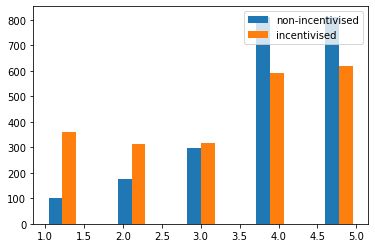

In [52]:
bins = np.linspace(1, 5,10)
#bins = 5
plt.hist([dfS['rating'], dfH['rating']], bins, label=['non-incentivised', 'incentivised'])
plt.legend(loc='upper right')
plt.show()

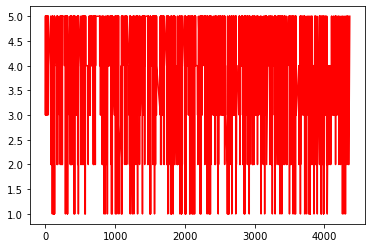

In [53]:
plt.plot(dfS['rating'], color = 'r')
plt.show()

In [54]:
df.to_csv('D:\\IIM\\Thesis\\Chap 2\\YelpChiIncFeat.csv',index = False)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4406 entries, 0 to 4405
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4406 non-null   object 
 1   user_id        4406 non-null   int64  
 2   prod_id        4406 non-null   int64  
 3   rating         4406 non-null   int64  
 4   reviews        4406 non-null   object 
 5   label          4406 non-null   int64  
 6   burst          4406 non-null   int64  
 7   PosSent        4406 non-null   float64
 8   NegSent        4406 non-null   float64
 9   CompSent       4406 non-null   float64
 10  avg_PSent      4406 non-null   float64
 11  med_PSent      4406 non-null   float64
 12  fSent          4406 non-null   float64
 13  incentivised   4406 non-null   int64  
 14  avg_Urating    4406 non-null   float64
 15  avg_Prating    4406 non-null   float64
 16  UCcounts       4406 non-null   int64  
 17  PCcounts       4406 non-null   int64  
 18  #ofwords

In [32]:
import pandas as pd
df = pd.read_csv("D:\\Yelp\\YelpNYC\\YNProcessed.csv")
df

,user_id,prod_id,rating,reviews,label,avg_Urating,avg_Prating,Var_Urating,Var_Prating,UCcounts,...,sadness,surprise,trust,Entropy,similarity,Ext,singleton,ratio_LCAPS,date,date_entropy
0,25179,80,5,great chicken be not dry sandwich fry definite...,1,5.0,4.008621,0.0,0.982833,1,...,0.000000,0.000000,0.071429,0.0,0.0,1,1,0.023256,3/19/2005,0
1,25178,88,5,great chicken be not dry sandwich fry definite...,1,5.0,4.203704,0.0,0.634088,1,...,0.000000,0.000000,0.071429,0.0,0.0,1,1,0.023256,5/18/2005,0
2,37625,120,4,crazy ridiculous experience artichoke basille ...,0,4.0,4.450085,0.0,0.202576,1,...,0.028986,0.043478,0.028986,0.0,0.0,0,1,0.044487,5/23/2005,0
3,37497,308,5,crazy ridiculous experience artichoke basille ...,1,5.0,3.736292,0.0,1.596957,1,...,0.028986,0.043478,0.028986,0.0,0.0,1,1,0.044487,5/25/2005,0
4,76285,890,5,go order panino rustico since open sit quiet r...,1,5.0,3.777778,0.0,1.493827,1,...,0.017857,0.053571,0.089286,0.0,0.0,1,1,0.028513,6/21/2005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73765,141898,641,4,great ukrainian restaurant soho good food grea...,1,4.0,3.823529,0.0,0.031142,1,...,0.052632,0.105263,0.157895,0.0,0.0,0,1,0.038710,1/6/2015,0
73766,59671,799,4,daunting mission try thai restaurant hells kit...,1,4.0,3.705882,0.0,0.086505,1,...,0.006098,0.018293,0.036585,0.0,0.0,0,1,0.031332,1/6/2015,0
73767,13129,439,4,good pancake worth hour wait tho sweet bacon b...,1,4.0,3.923077,0.0,0.005917,1,...,0.000000,0.090909,0.090909,0.0,0.0,0,1,0.042056,1/6/2015,0
73768,73670,352,4,try fuji apple pie eight turn crepe caramelize...,1,4.0,3.703704,0.0,0.087791,1,...,0.000000,0.102941,0.073529,0.0,0.0,0,1,0.033159,1/7/2015,0


In [2]:
dfB = df.loc[:,df.isin([0,1]).all()] 
dfB

,label,Exclaim,Ext,singleton
0,1,0,1,1
1,1,0,0,1
2,0,0,0,0
3,0,1,1,0
4,1,0,1,1
...,...,...,...,...
157869,1,1,0,1
157870,1,1,1,1
157871,1,0,0,1
157872,1,1,0,1


In [17]:
dfF.iloc[:,:-1].columns

Index(['avg_Urating', 'avg_Prating', 'Var_Urating', 'Var_Prating', 'UCcounts',
       'PCcounts', '#ofwords', 'Uavg#word', 'Uvar#word', 'Pavg#word',
       'Pvar#word', 'day_Urating', 'day_Prating', '#ofCharacter', 'Uppercase',
       'Lowercase', 'count_punct', 'Exclaim', 'subjectivity', 'positiveSent',
       'negativeSent', 'le_d', 'ld', 'anger', 'anticipation', 'disgust',
       'fear', 'joy', 'sadness', 'surprise', 'trust', 'Entropy', 'similarity',
       'Ext', 'singleton', 'ratio_LCAPS', 'date_entropy'],
      dtype='object')

In [33]:
dfF= df[['avg_Urating', 'avg_Prating', 'Var_Urating', 'Var_Prating', 'UCcounts',
       'PCcounts', '#ofwords', 'Uavg#word', 'Uvar#word', 'Pavg#word',
       'Pvar#word', 'day_Urating', 'day_Prating', '#ofCharacter', 'Uppercase',
       'Lowercase', 'count_punct', 'Exclaim', 'subjectivity', 'positiveSent',
       'negativeSent', 'le_d', 'ld', 'anger', 'anticipation', 'disgust',
       'fear', 'joy', 'sadness', 'surprise', 'trust', 'Entropy', 'similarity',
       'Ext', 'singleton', 'ratio_LCAPS', 'date_entropy','label']]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

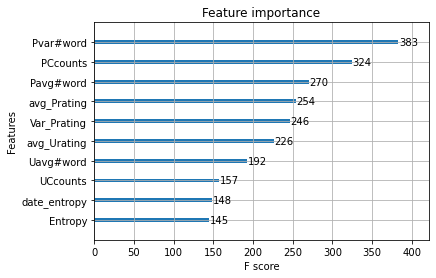

In [34]:
from xgboost import XGBClassifier
from xgboost import plot_importance
xgb = XGBClassifier(random_state = 44, nthread = 4)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfF.iloc[:,:-1], dfF.iloc[:,-1], test_size=0.30, random_state=42)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
xgb.feature_importances_
plot_importance(xgb,max_num_features=10)

In [16]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.34%


<AxesSubplot:>

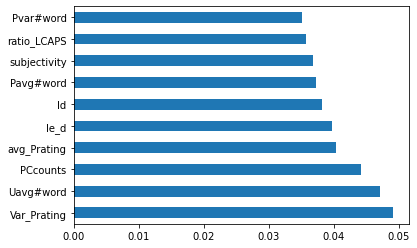

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=22, n_jobs = -1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
feat_importances = pd.Series(clf.feature_importances_, index=dfF.iloc[:,:-1].columns)
feat_importances.nlargest(10).plot(kind='barh')

In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.63%


Text(0.5, 0, 'Permutation Importance')

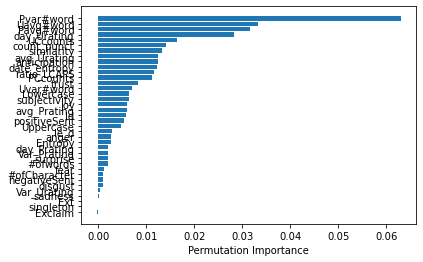

In [35]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import shap
perm_importance = permutation_importance(xgb, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(dfF.iloc[:,:-1].columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

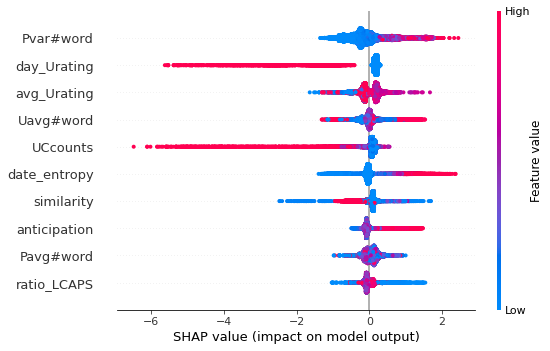

In [36]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,max_display=10)


In [22]:
pip install shap

Note: you may need to restart the kernel to use updated packages.
